In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

BASE_PATH = Path("/LOCAL/fmahner/srf/results/benchmarks")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


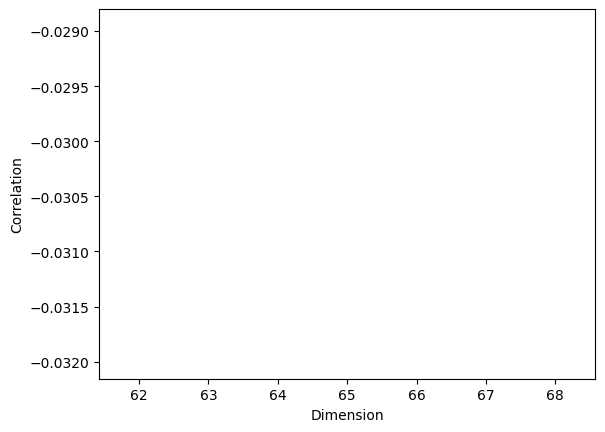

In [3]:
spose_recovery = pd.read_csv(BASE_PATH / "spose_reconstruction.csv")
# plot for snr = 1.0
sns.lineplot(
    x="Dimension", y="Correlation", data=spose_recovery[spose_recovery["SNR"] == 1.0]
)
plt.show()

### RSA Hypothesis Testing


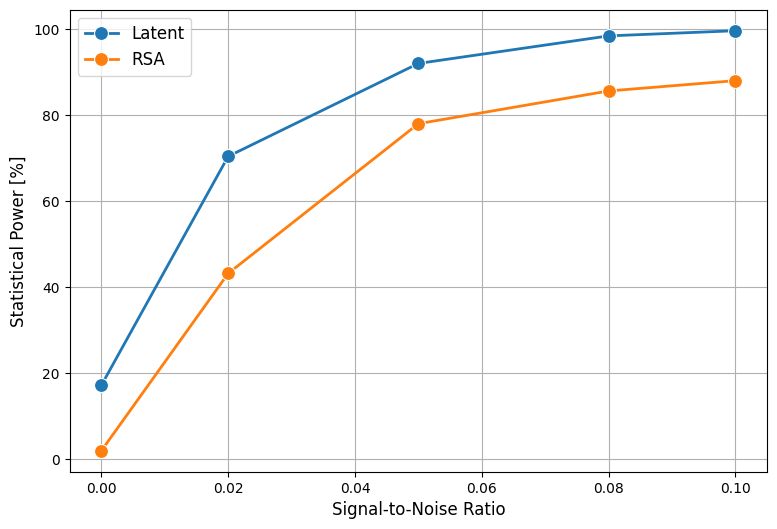

In [5]:
# power is the number of times we reject the null hypothesis divided by the total number of permutations
# Average over per
results_df = pd.read_csv(BASE_PATH / "hypothesis_tests.csv")

# Drop NMF
results_df = results_df[results_df["Method"] != "NMF"]
power_df = results_df.groupby(["SNR", "Method"])["Significant"].mean().reset_index()
power_df["Significant"] *= 100  # Convert to percentage
# Create plot using seaborn
plt.figure(figsize=(9, 6))
sns.lineplot(
    data=power_df,
    x="SNR",
    y="Significant",
    hue="Method",
    marker="o",
    linewidth=2,
    markersize=10,
)

plt.xlabel("Signal-to-Noise Ratio", fontsize=12)
plt.ylabel("Statistical Power [%]", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

In [30]:
from srf.helpers import load_spose_embedding
from scipy.stats import pearsonr


x = load_spose_embedding()
x1 = x[0, :2].reshape(1, -1)
w1 = x1

a = np.eye(2)

s_hat = w1 @ a @ w1.T
s = x1 @ x1.T
print(s, s_hat)

a = np.eye(2)
a[0, 0] = 1
a[0, 1] = 100
a[1, 0] = 100

print(a)
s_hat = w1 @ a @ w1.T
s = x1 @ x1.T
print(s, s_hat)

[[0.09089908]] [[0.09089908]]
[[  1. 100.]
 [100.   1.]]
[[0.09089908]] [[0.62349216]]


In [ ]:
from srf.utils import load_spose_embedding
from srf.models.trifactor import TriFactor
import numpy as np


max_dims = 66
spose = load_spose_embedding(max_objects=1854, max_dims=max_dims)
rsm = spose @ spose.T
rsm /= rsm.max()


model = TriFactor(
    rank=max_dims,
    alpha=1.0,
    max_iter=1000,
    verbose=True,
)

# model = SymTriFactorIter(
#     rank=max_dims,
#     max_iter=200,
#     verbose=True,
# )
model.fit(rsm)

In [18]:
np.diag(model.a_)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<Axes: >

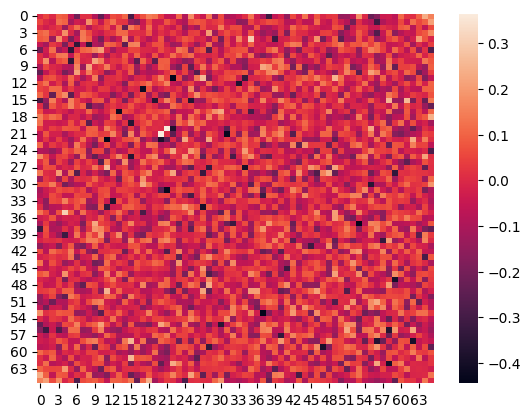

In [19]:
a = model.a_
np.fill_diagonal(a, 0.0)
sns.heatmap(a)

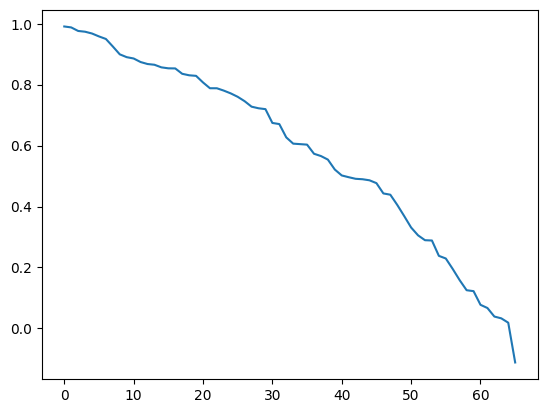

In [21]:
w = model.w_
h = model.h_
a = model.a_


out = greedy_match(w, spose)
corrs = [m[0] for m in out]
plt.plot(corrs)

In [27]:
a.min()

np.float64(-0.444411360693357)

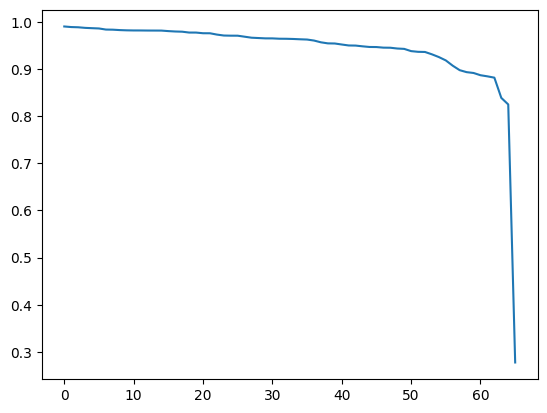

In [22]:
from scipy.linalg import orthogonal_procrustes

W = model.w_
X = spose
Q, _ = orthogonal_procrustes(W, X)  # find best orthogonal alignment X→W
W_rot = W @ Q  # rotate into X’s frame

# now use your greedy or Hungarian matching
out = greedy_match(X, W_rot)
corrs = [m[0] for m in out]
plt.plot(corrs)